In [37]:
import jax.numpy as jnp 
from jax import grad, jit, vmap, jacfwd, hessian, random
from jax.tree_util import tree_map
from jax.flatten_util import ravel_pytree
from jax.experimental.ode import odeint 
from jax.scipy.stats import norm
import matplotlib.pyplot as plt

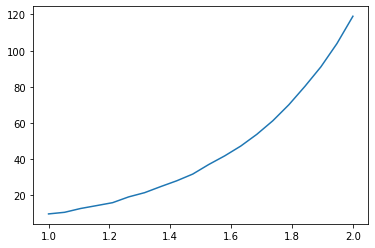

In [15]:
# forward function
def forward(params, x):
    return params[1] * jnp.exp(params[0] * x)

# simulation
x = jnp.linspace(1., 2., 20)
# {"a": 2.5, "b": 0.8}
params_true = jnp.array([2.5, 0.8])
noise = random.normal(key=random.PRNGKey(123), shape=(len(x),)) * 0.3
y = forward(params=params_true, x=x) + noise

plt.plot(x, y)

### Levenberg-Marquardt Method
Add a small constant ($\lambda$) to the Hessian such that the Hessian remains positive definite

$$\theta_{i+1} = \theta_{i} - [\nabla^2 + \lambda I]^{-1} \nabla$$

In [49]:
# MLE
def neg_loglikelihood(params, x, y):
    mu = params[1] * jnp.exp(params[0] * x)
    sigma = params[2]
    return - jnp.sum(norm.logpdf(y, loc=mu, scale=sigma))

# {"a": 10., "b": 1., "sigma": 0.5}
params = jnp.array([10. ,1., 2.])
n_iter = 1000

# Levenberg-Margquard Method
for i in range(n_iter):
    jacob = jacfwd(neg_loglikelihood, argnums=0)
    jac   = jacob(params, x, y)
    
    hess  = hessian(neg_loglikelihood, argnums=0)
    hes   = hess(params, x, y)
    
    cost = neg_loglikelihood(params, x, y)
    
    params -= jnp.linalg.inv(hes + 1e3*jnp.identity(hes.shape[0])) @ jac.T 
    
    if i % (n_iter/10) == 0:
        print(f"Iter: {i:8} | Loss: {cost} | Update: {params}")
    

Iter:        0 | Loss: 4.5198088339456e+16 | Update: [9.746571  1.0005866 2.0011725]
Iter:      100 | Loss: 48.97931671142578 | Update: [ 2.3795934  0.9990412 -4.434036 ]
Iter:      200 | Loss: 46.01655578613281 | Update: [ 2.489788   0.8157735 -3.965941 ]
Iter:      300 | Loss: 43.128326416015625 | Update: [ 2.4937558  0.8098304 -3.428121 ]
Iter:      400 | Loss: 39.065399169921875 | Update: [ 2.4937947  0.8097721 -2.7901664]
Iter:      500 | Loss: 32.170284271240234 | Update: [ 2.493795   0.8097717 -1.9601597]
Iter:      600 | Loss: 6.399808883666992 | Update: [ 2.4937952  0.8097714 -0.4101621]
Iter:      700 | Loss: 4.199045181274414 | Update: [ 2.4937952   0.8097714  -0.29849976]
Iter:      800 | Loss: 4.199045181274414 | Update: [ 2.4937952   0.8097714  -0.29849976]
Iter:      900 | Loss: 4.199045181274414 | Update: [ 2.4937952   0.8097714  -0.29849976]


### Error Variance (Mean Square Error)
$$\hat \sigma^2 = MSE = \frac{SSE}{n-p}=\frac{\Sigma(Y_i - \hat Y_i)^2}{n-p}$$
### Parameter Variance-Covariance Matrix
$$Var(\hat \theta) = \Sigma = \hat \sigma^2 \times (J^TJ)^{-1}$$
- J: Jacobian evaluated at $\hat \theta$
- $\Sigma$: p x p matrix whose diaonal elements are the variances of the parameter estimates
- most softwares use this as the default variance estimator

In [50]:
# Error Variance
cost = jnp.sum(jnp.square(forward(params, x) - y))
MSE = cost / (len(x) - 3)
# Covariance Matrix
COV = MSE * jnp.linalg.inv(hes)

COV

DeviceArray([[ 4.5117554e-06, -6.6866919e-06,  1.2525055e-10],
             [-6.6866919e-06,  1.0010970e-05, -2.4918179e-11],
             [ 1.4362667e-10, -5.2093749e-11,  2.3350553e-04]],            dtype=float32)

In [51]:
# covariance can be approximated by the inverse of negative hessian matrix
COV_h = jnp.linalg.inv(-hes)
COV_h

DeviceArray([[-4.3040429e-05,  6.3788495e-05, -1.1948426e-09],
             [ 6.3788495e-05, -9.5500844e-05,  2.3770994e-10],
             [-1.3701437e-09,  4.9695453e-10, -2.2275539e-03]],            dtype=float32)